In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [32]:
Xtrain = mnist.train.images
Xtest = mnist.test.images

In [100]:
Xtrain.shape

(55000, 784)

In [33]:
del mnist

In [64]:
def xavier_init(inputShape, outputShape): 
    low = -np.sqrt(6.0/(inputShape + outputShape)) 
    return tf.random_uniform((inputShape, outputShape), 
                             minval=low, maxval=-low, 
                             dtype=tf.float32)

class FullyConnectLayer(object):
    
    def __init__(self,inputLayer,actFun,outputShape):
        self.inputShape = inputLayer.outputShape
        self.inputLayer = inputLayer
        self.actFun = actFun
        self.outputShape  = outputShape
        self.W = tf.Variable(xavier_init(self.inputShape,self.outputShape))
        self.b = tf.Variable(tf.zeros([self.outputShape]))
        self.output = actFun(tf.matmul(self.inputLayer.output,self.W) + self.b)


class InputLayer(object):
    
    def __init__(self,input_):
        self.output = input_
        self.outputShape = input_.get_shape().as_list()[1]


In [146]:
class VAE(object):
    
    def __init__(self,encoderShapes,decoderShapes,batchSize,encoderActFun,decoderActFun,r):
        self.X = tf.placeholder(tf.float32,[batchSize,decoderShapes[-1]])
        self.r = r
        self.batchSize = batchSize
        self.zShape = encoderShapes[-1]/2
        layer = InputLayer(self.X)
        
        # encoder
        for s,fun in zip(encoderShapes,encoderActFun): 
            layer = FullyConnectLayer(layer,fun,s)
        self.mu, self.logSigma = tf.split(layer.output,2,1)
        sigma = tf.exp(self.logSigma)
        eps = tf.random_normal([batchSize,self.zShape], 0, 1, 
                       dtype=tf.float32)
        
        # decoder
        self.z = self.mu + tf.sqrt(sigma) * eps
        layer = InputLayer(self.z)
        for s,fun in zip(decoderShapes,decoderActFun): 
            layer = FullyConnectLayer(layer,fun,s)
        
        self.sample = tf.nn.sigmoid(layer.output)
        # loss
        KL = 0.5*tf.reduce_sum(sigma + tf.square(self.mu) - 1 - self.logSigma)
        logP = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=self.X, logits=layer.output))
        self.loss = (KL + logP)/batchSize
        
        # optimizer
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.r).minimize(self.loss)
        
        # session
        init = tf.global_variables_initializer()
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
    
    def _partial_fit(self,X_np):
        _,loss = self.sess.run([self.optimizer, self.loss],{self.X:X_np})
        return loss
    
    def fit(self,X,iterations):
        N = X.shape[0]
        n = N/self.batchSize
        for i in range(iterations):
            index_ = np.random.permutation(N)
            cumLoss = 0
            for j in range(n):
                cumLoss += self._partial_fit(X[index_[j*self.batchSize:(j+1)*self.batchSize]])
            print "iter :{}, loss :{}".format(i,cumLoss/n)        
    
    def encode(self,X):
        return self.sess.run(self.mu,{self.X:X})
    
    def sampleFun(self,Z=None):
        if Z is None:
            Z = np.random.randn(self.batchSize, self.zShape)
        return self.sess.run(self.sample,{self.z:Z})

In [147]:
v1 = VAE([500,400],[500,784],100,[tf.nn.relu,tf.nn.relu],[tf.nn.relu,tf.identity],1e-3)

In [148]:
v1.fit(Xtrain,20)

iter :0, loss :181.066166798
iter :1, loss :154.650279957
iter :2, loss :149.264145508
iter :3, loss :146.477014493
iter :4, loss :144.615528259
iter :5, loss :143.158653287
iter :6, loss :142.139706171
iter :7, loss :141.41271415
iter :8, loss :140.709201688
iter :9, loss :140.173265159
iter :10, loss :139.647459425
iter :11, loss :139.193574774
iter :12, loss :138.752676225
iter :13, loss :138.393744729
iter :14, loss :137.973327526
iter :15, loss :137.754626395
iter :16, loss :137.503619523
iter :17, loss :137.252208737
iter :18, loss :136.998397245
iter :19, loss :136.605181025


Look at random sample from P(X)

In [149]:
s1 = v1.sampleFun()

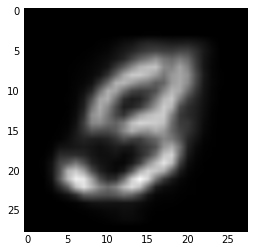

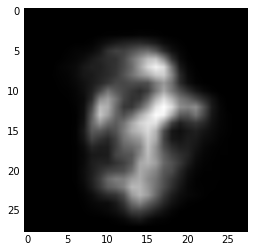

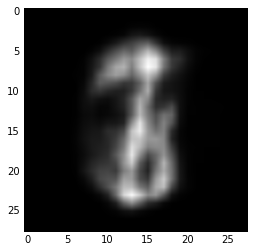

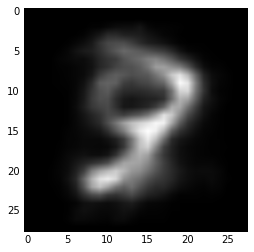

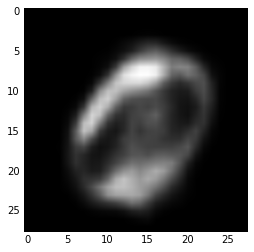

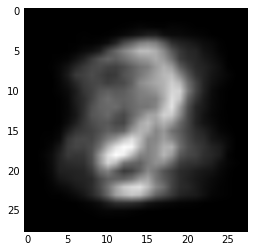

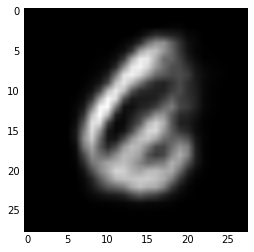

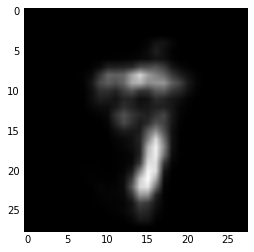

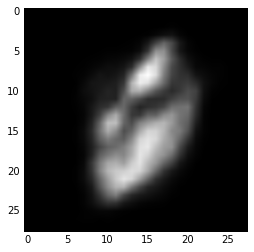

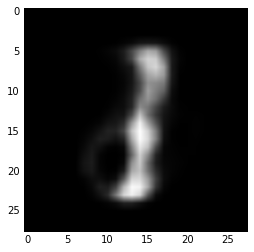

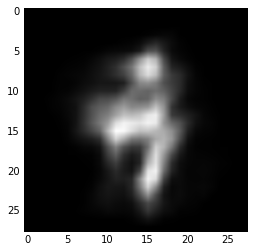

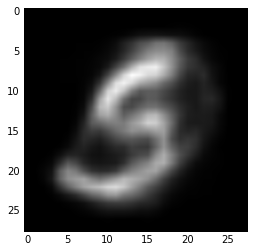

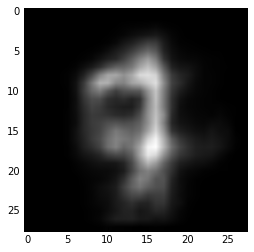

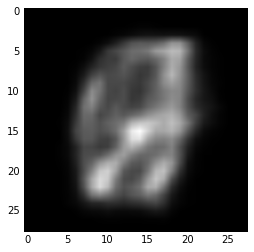

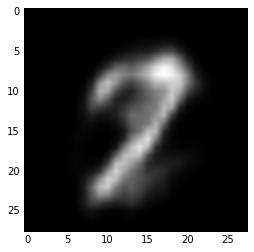

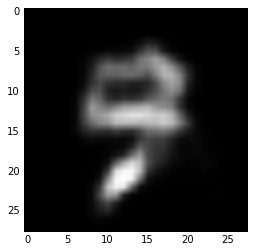

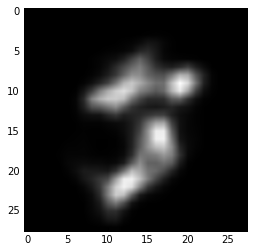

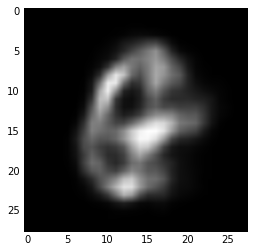

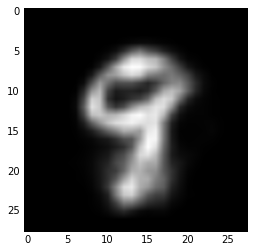

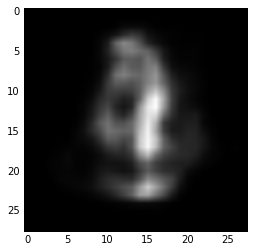

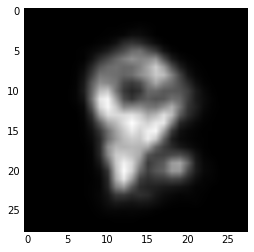

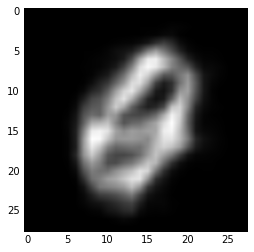

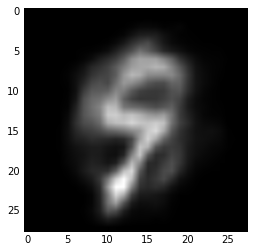

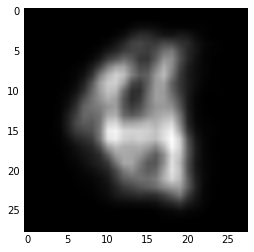

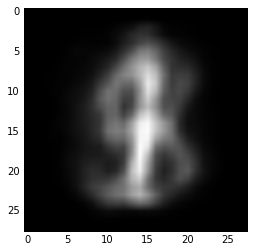

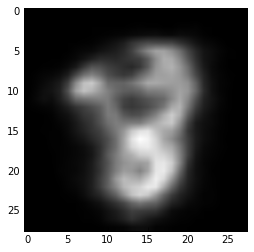

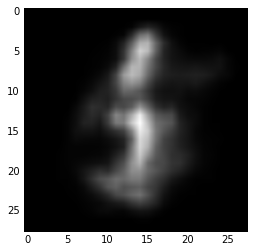

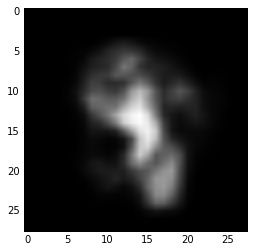

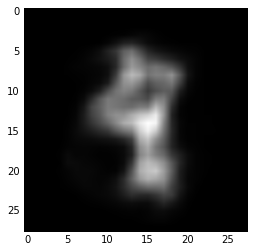

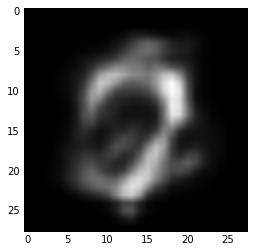

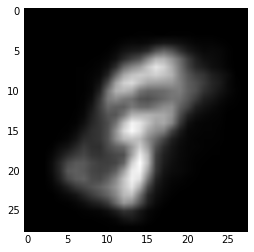

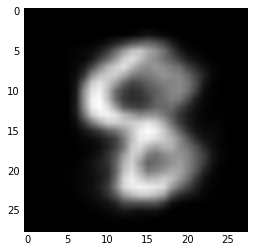

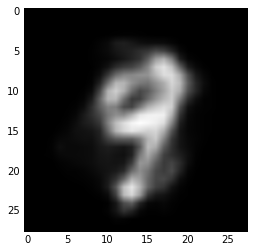

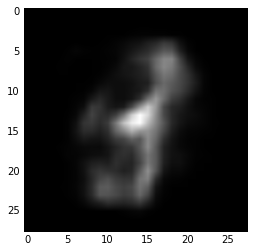

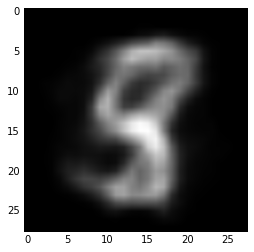

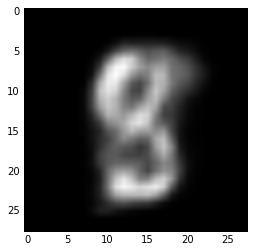

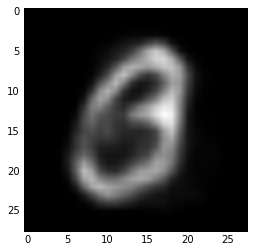

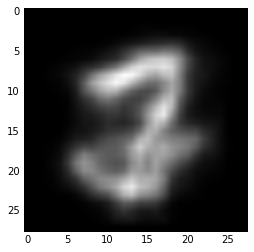

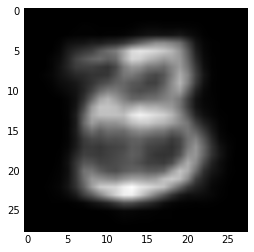

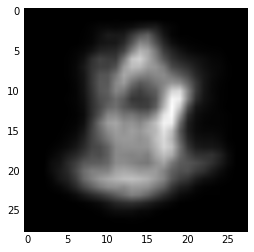

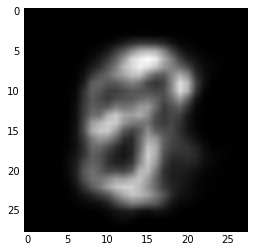

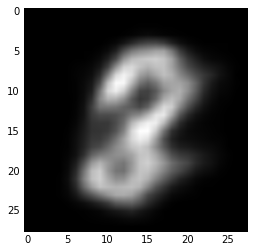

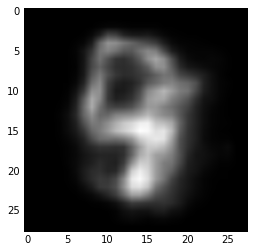

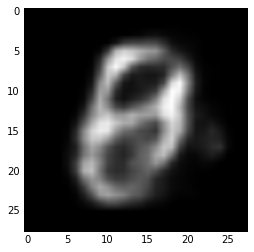

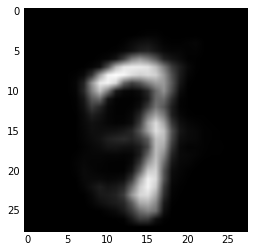

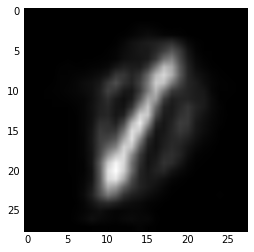

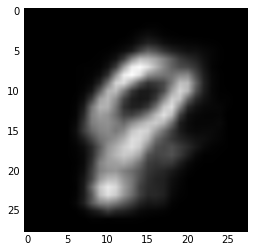

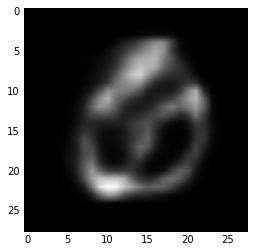

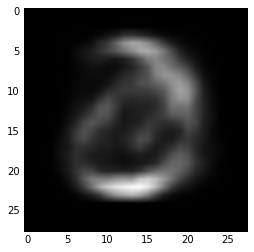

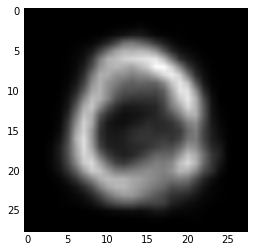

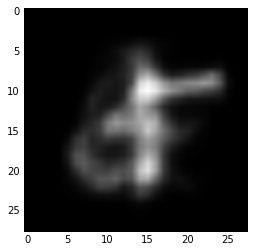

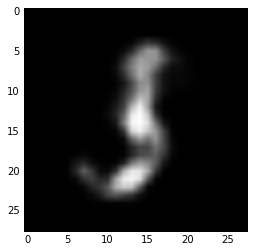

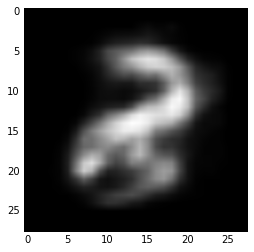

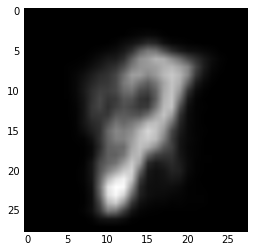

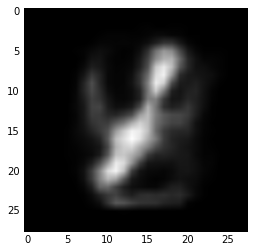

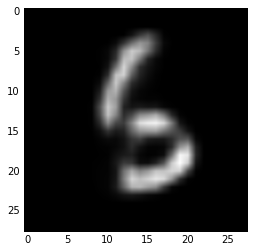

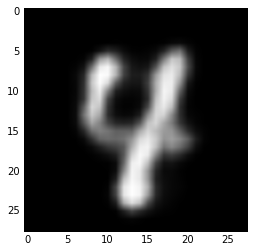

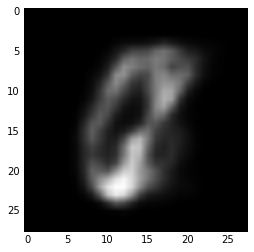

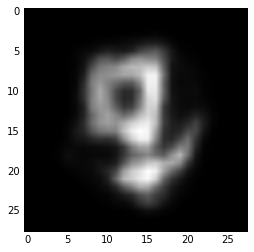

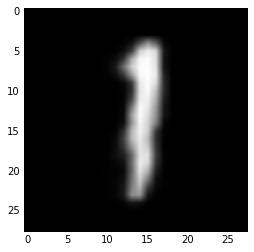

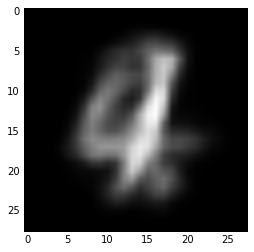

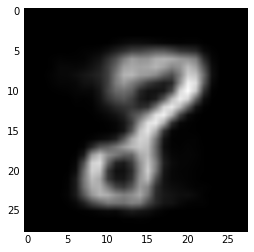

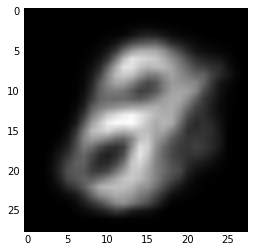

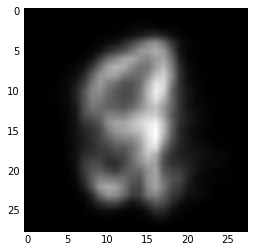

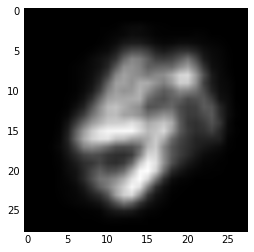

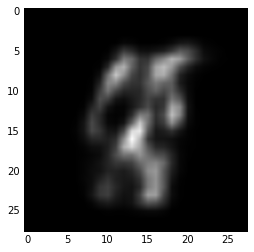

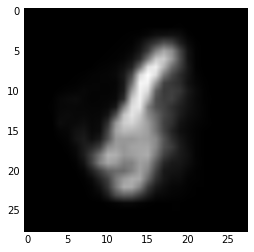

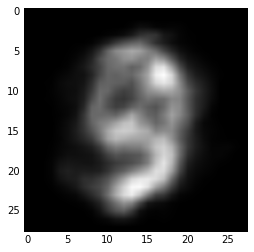

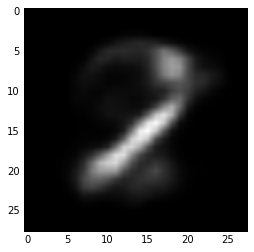

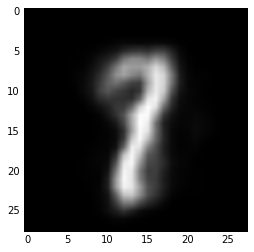

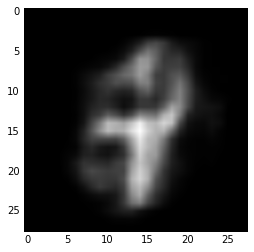

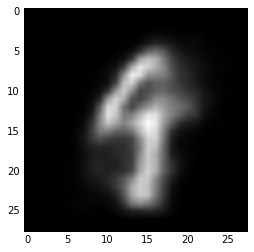

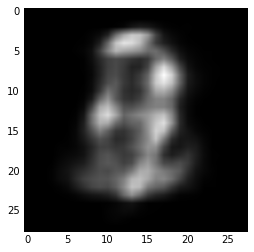

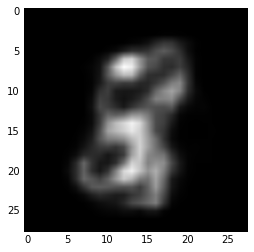

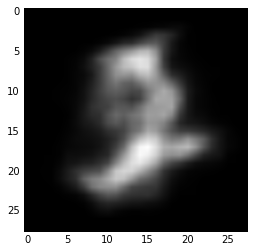

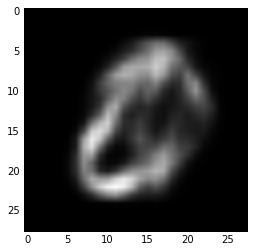

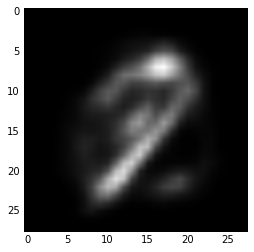

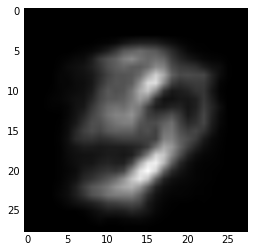

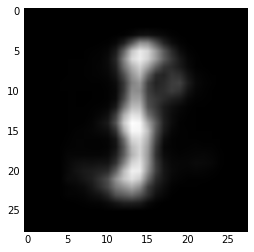

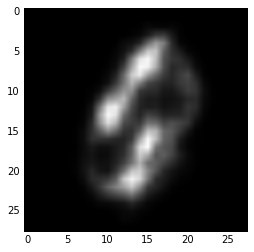

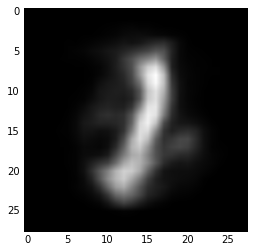

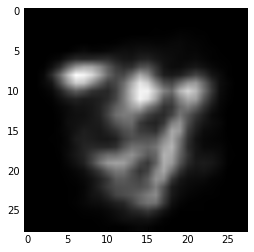

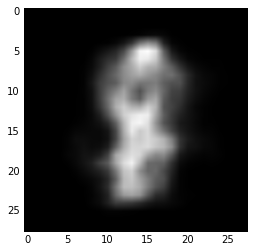

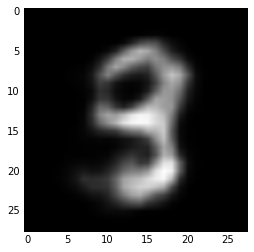

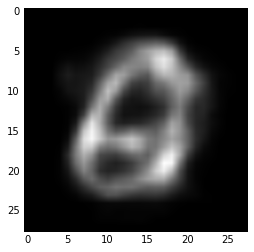

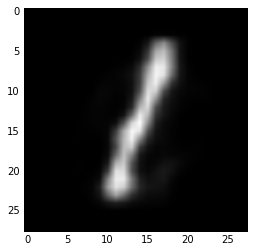

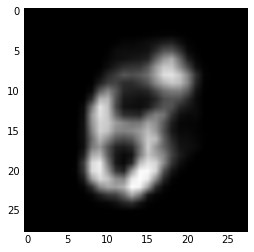

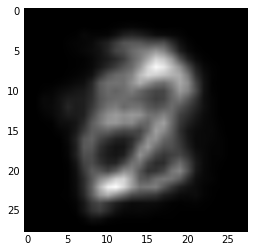

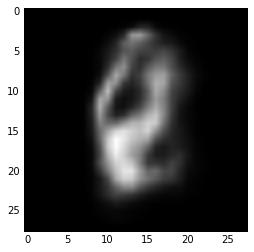

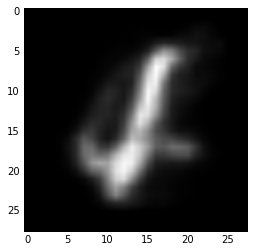

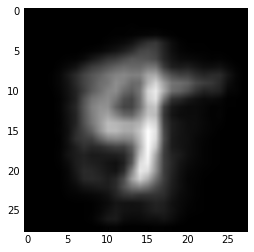

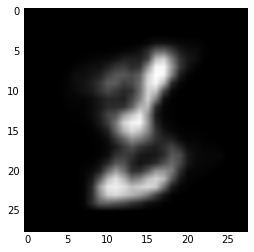

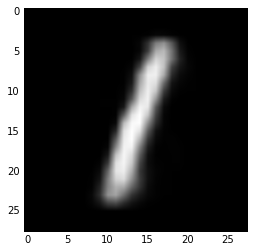

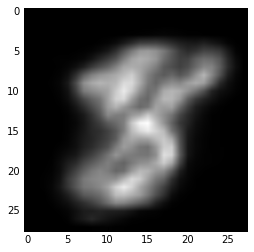

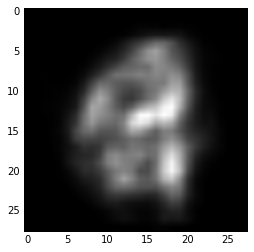

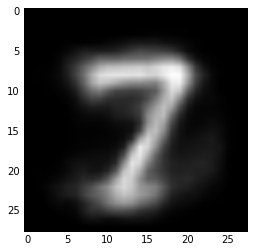

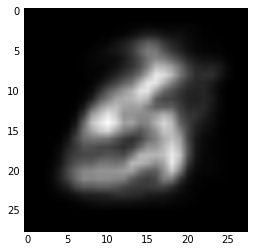

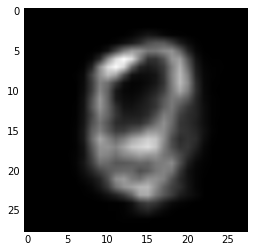

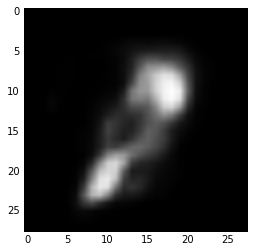

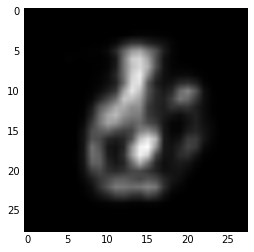

In [150]:
for s in s1:
    plt.imshow(np.reshape(s,(28,28)),cmap='gray')
    plt.show()

Look at reconstruction

In [151]:
rec1 = v1.sampleFun(v1.encode(Xtest[:100]))

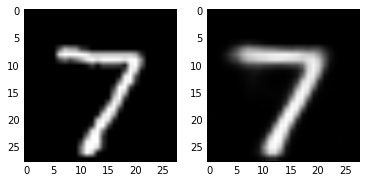

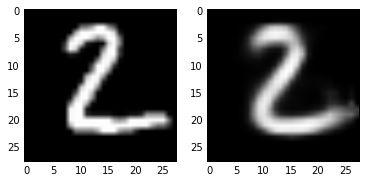

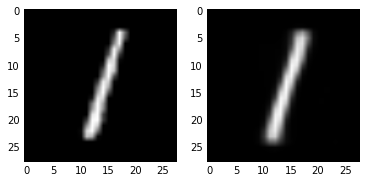

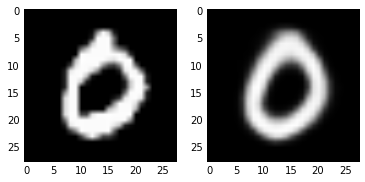

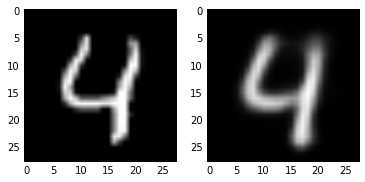

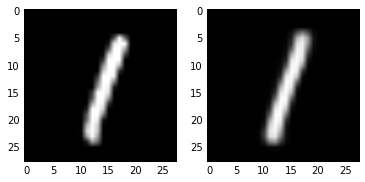

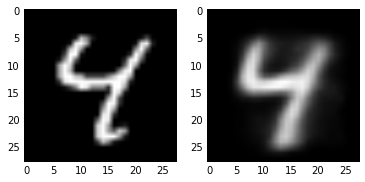

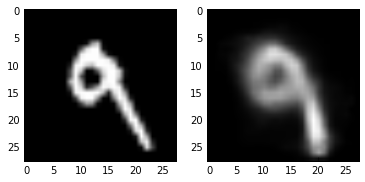

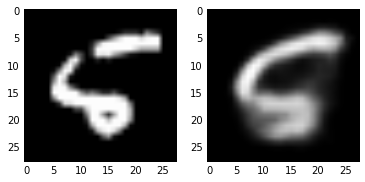

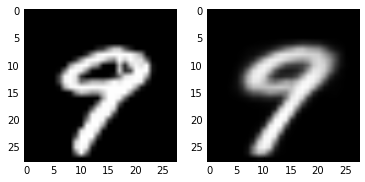

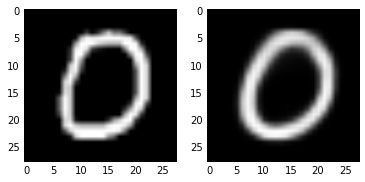

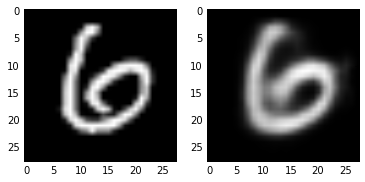

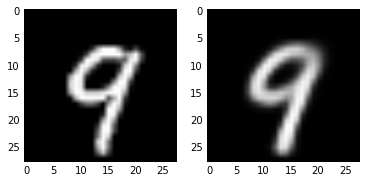

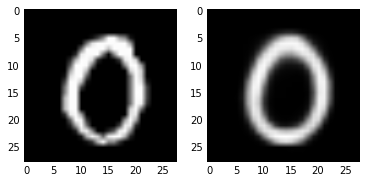

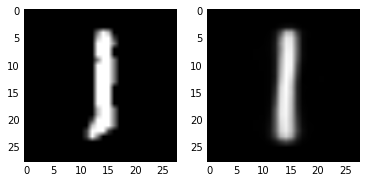

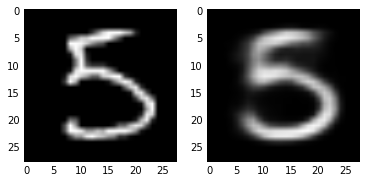

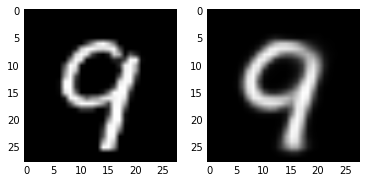

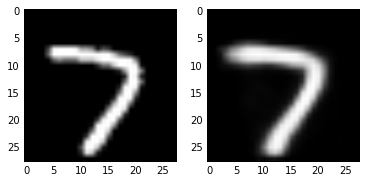

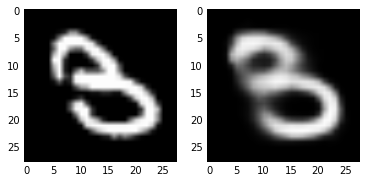

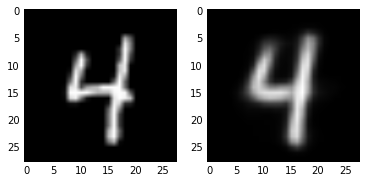

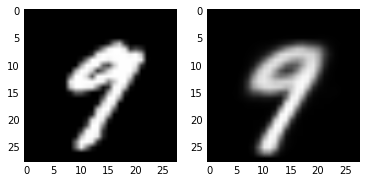

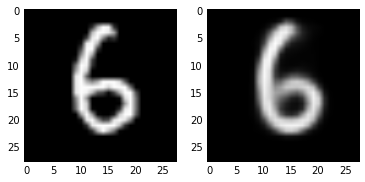

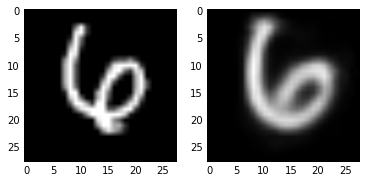

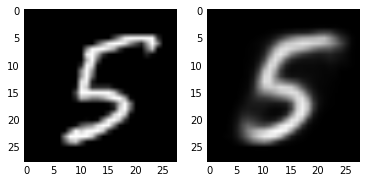

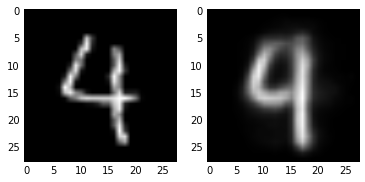

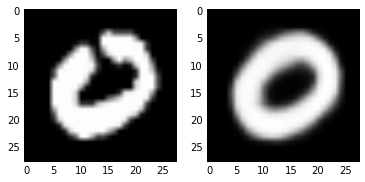

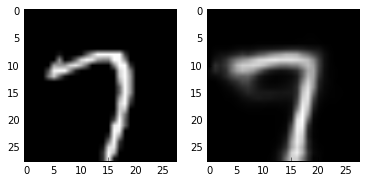

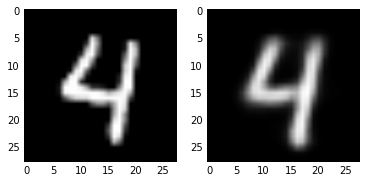

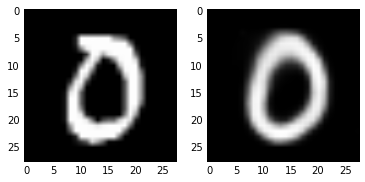

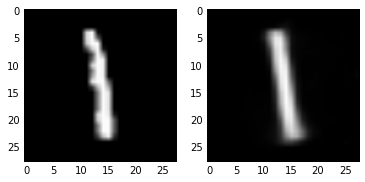

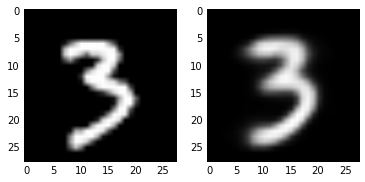

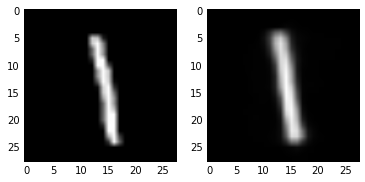

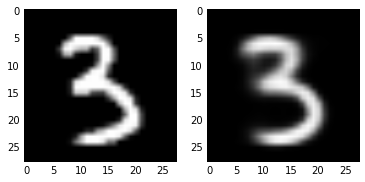

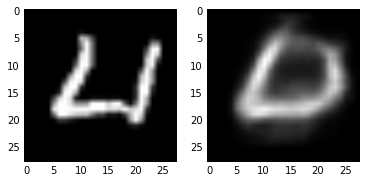

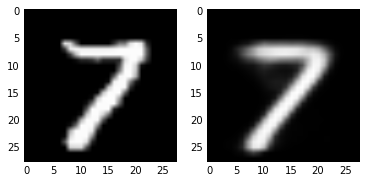

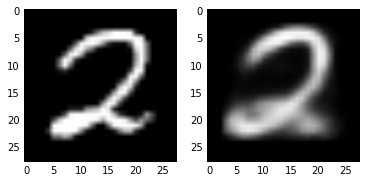

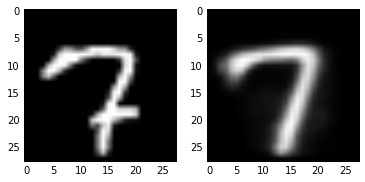

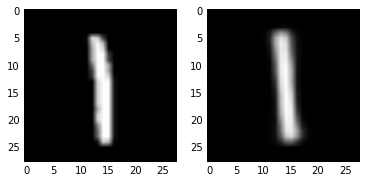

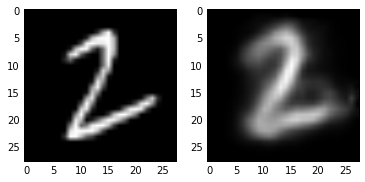

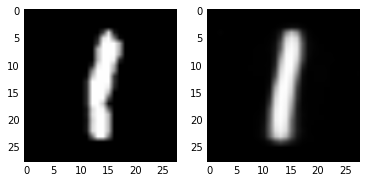

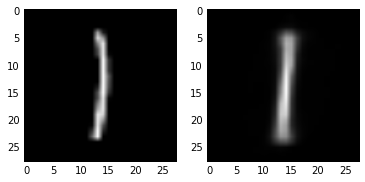

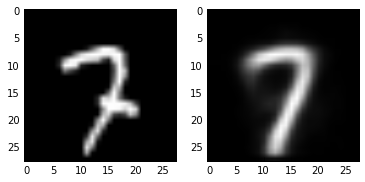

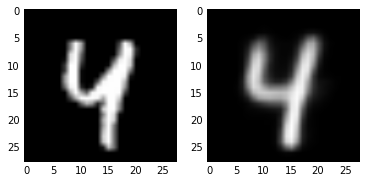

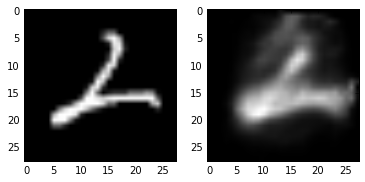

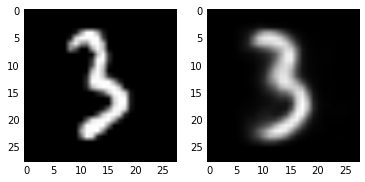

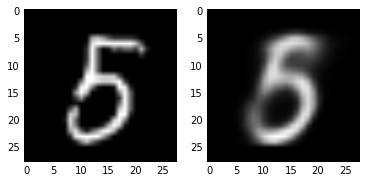

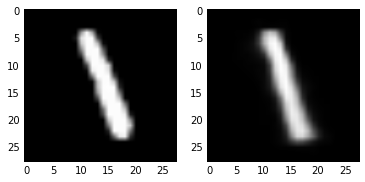

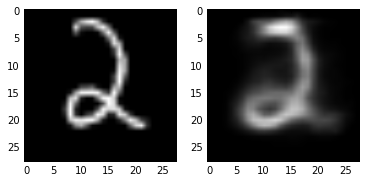

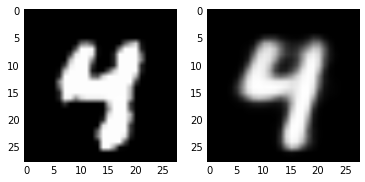

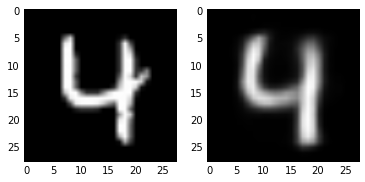

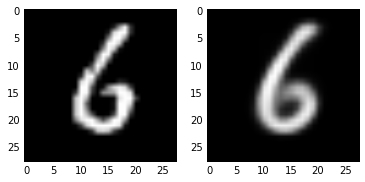

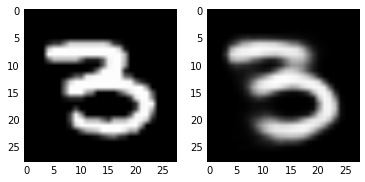

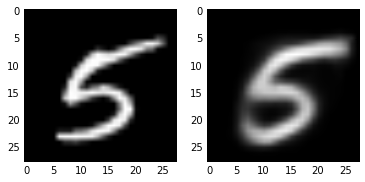

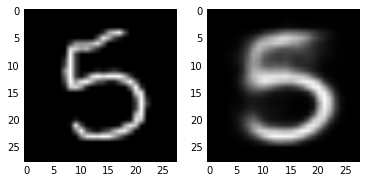

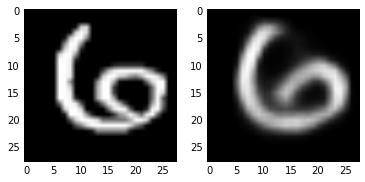

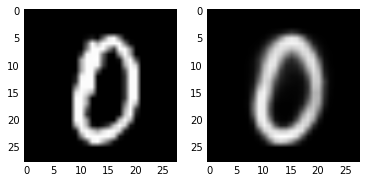

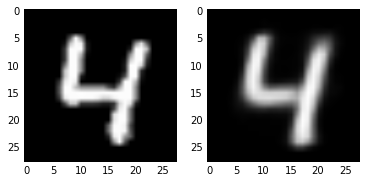

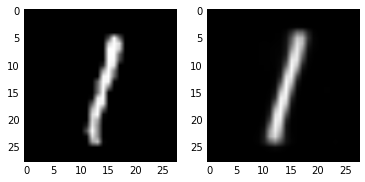

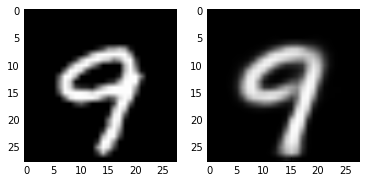

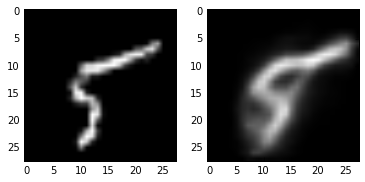

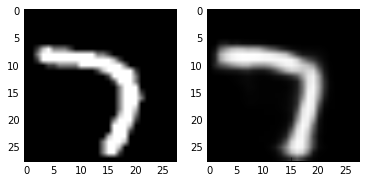

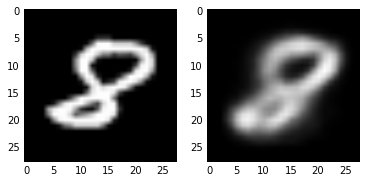

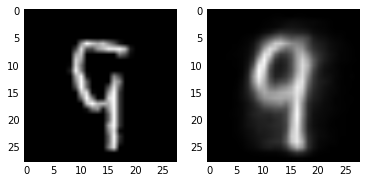

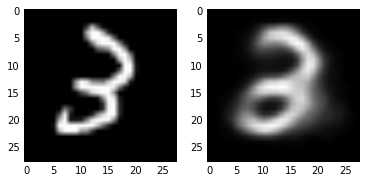

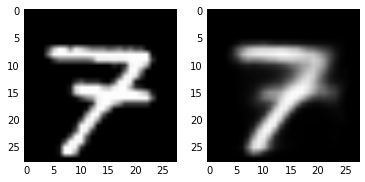

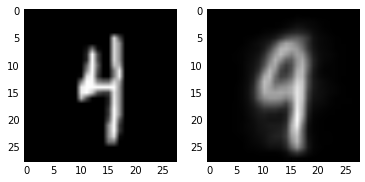

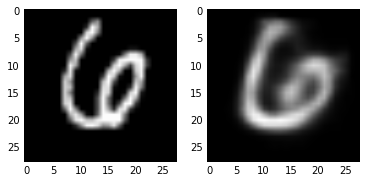

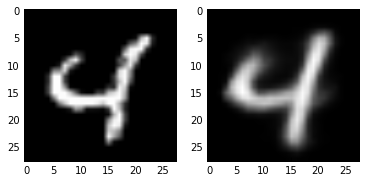

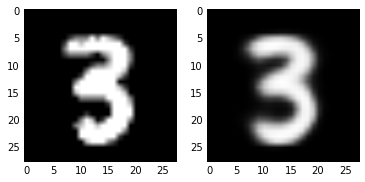

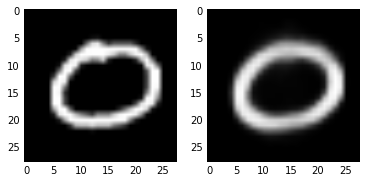

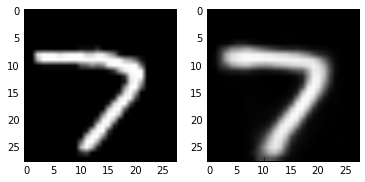

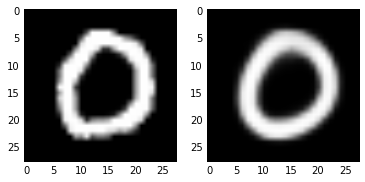

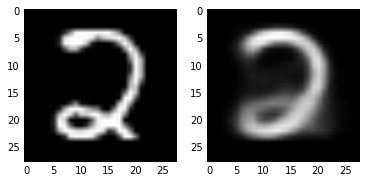

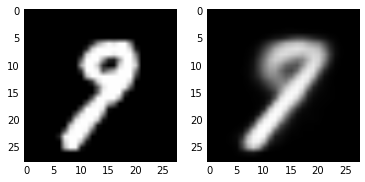

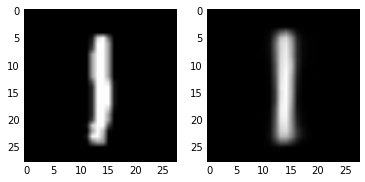

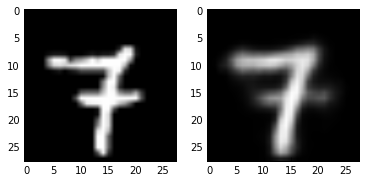

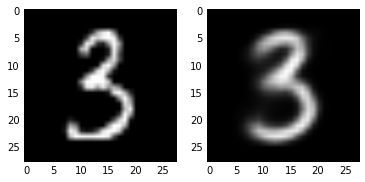

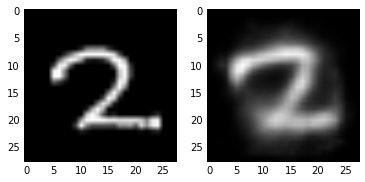

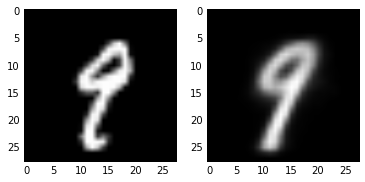

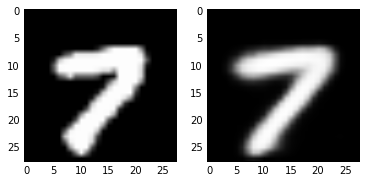

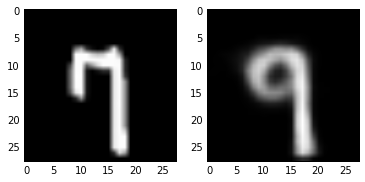

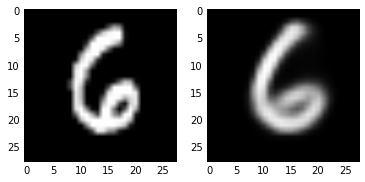

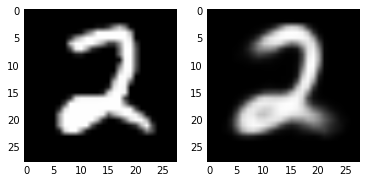

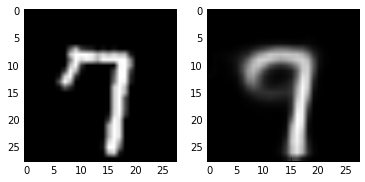

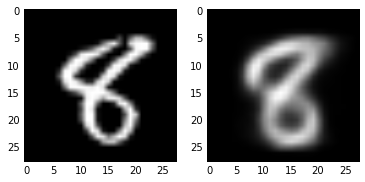

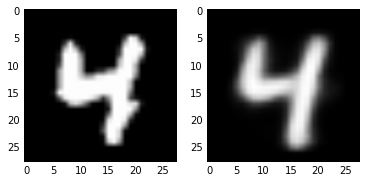

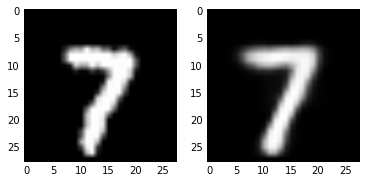

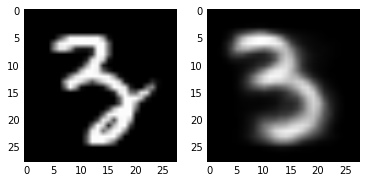

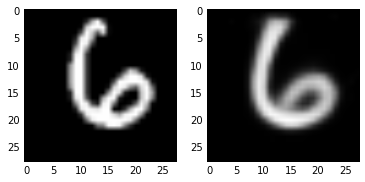

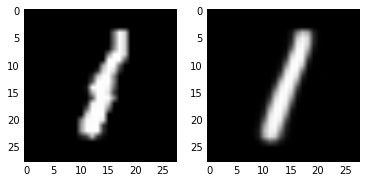

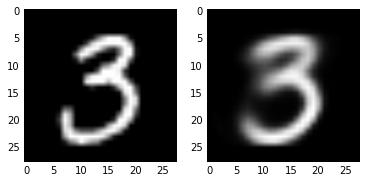

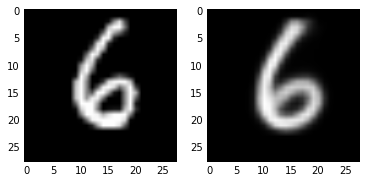

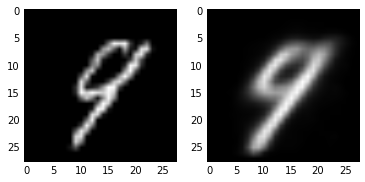

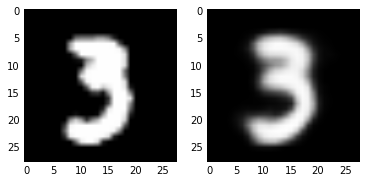

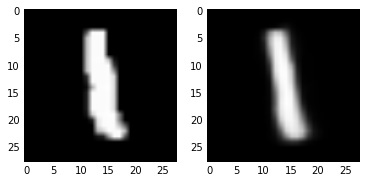

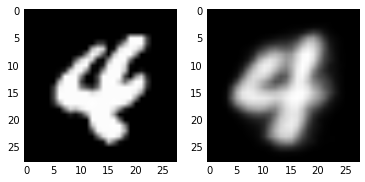

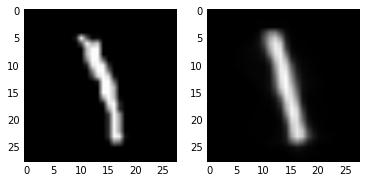

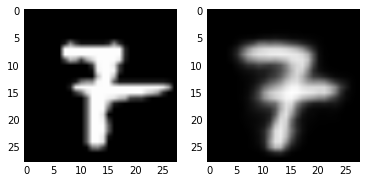

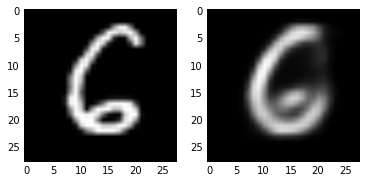

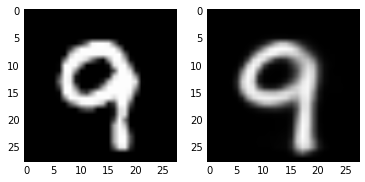

In [158]:
for i in range(100):
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(np.reshape(Xtest[i],(28,28)),cmap='gray')
    axarr[1].imshow(np.reshape(rec1[i],(28,28)),cmap='gray')
    plt.show()